In [1]:
import os
import pandas as pd
import numpy as np
from IPython.core.display import HTML
import geopy.distance
from geopy.distance import great_circle, geodesic
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import pickle

pd.set_option('display.max_rows', 1000)

# Load Data

In [2]:
testData = pd.read_csv('test.csv')
testData

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1
...,...,...,...,...,...,...
9909,2015-05-10 12:37:51 UTC,-73.968124,40.796997,-73.955643,40.780388,6
9910,2015-01-12 17:05:51 UTC,-73.945511,40.803600,-73.960213,40.776371,6
9911,2015-04-19 20:44:15 UTC,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19 UTC,-73.985573,40.735432,-73.939178,40.801731,6


In [3]:
# User defined function to convert to datetime format
def toDateTime(a):
    temp = []
    for i in a:
        temp.append(pd.to_datetime(i, errors='coerce'))
    return temp

In [4]:
testData['pickup_datetime'] = toDateTime(testData['pickup_datetime'])

# Missing Value Analysis

In [5]:
def calMissingValues(df):
    return df.isna().sum()

# Missing values in each column
print(calMissingValues(testData))
print('\n\nTotal missing values: ', testData.isna().sum().sum())

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


Total missing values:  0


There are no missing values in the test data.

# Outlier Analysis

In [6]:
# Checking if there are any Out of Range Values
def outOfRangeValues(df):
    print('pickup_longitude above 180 = {}'.format(sum(df['pickup_longitude']>180)))
    print('pickup_longitude below -180 = {}'.format(sum(df['pickup_longitude']<-180)))
    print('pickup_latitude above 90 = {}'.format(sum(df['pickup_latitude']>90)))
    print('pickup_latitude below -90 = {}'.format(sum(df['pickup_latitude']<-90)))
    print('dropoff_longitude above 180 = {}'.format(sum(df['dropoff_longitude']>180)))
    print('dropoff_longitude below -180 = {}'.format(sum(df['dropoff_longitude']<-180)))
    print('dropoff_latitude below -90 = {}'.format(sum(df['dropoff_latitude']<-90)))
    print('dropoff_latitude above 90 = {}'.format(sum(df['dropoff_latitude']>90)))
    
outOfRangeValues(testData)

pickup_longitude above 180 = 0
pickup_longitude below -180 = 0
pickup_latitude above 90 = 0
pickup_latitude below -90 = 0
dropoff_longitude above 180 = 0
dropoff_longitude below -180 = 0
dropoff_latitude below -90 = 0
dropoff_latitude above 90 = 0


There are no Out of Range Values.

In [7]:
# Checking if there are any values equal to zero.
def checkNumOfValuesEqualToZero(df):
    for i in ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
        print(i,'equal to 0 = {}'.format(sum(df[i]==0)))
        
checkNumOfValuesEqualToZero(testData)

pickup_longitude equal to 0 = 0
pickup_latitude equal to 0 = 0
dropoff_longitude equal to 0 = 0
dropoff_latitude equal to 0 = 0


There are no values equal to zero.

In [8]:
for i in range(1,15):
    print('Number of Clients with passenger_count value above ' + str(i) + ' = {}'.format(sum(testData['passenger_count'] >= i)))

Number of Clients with passenger_count value above 1 = 9914
Number of Clients with passenger_count value above 2 = 3000
Number of Clients with passenger_count value above 3 = 1526
Number of Clients with passenger_count value above 4 = 1079
Number of Clients with passenger_count value above 5 = 873
Number of Clients with passenger_count value above 6 = 177
Number of Clients with passenger_count value above 7 = 0
Number of Clients with passenger_count value above 8 = 0
Number of Clients with passenger_count value above 9 = 0
Number of Clients with passenger_count value above 10 = 0
Number of Clients with passenger_count value above 11 = 0
Number of Clients with passenger_count value above 12 = 0
Number of Clients with passenger_count value above 13 = 0
Number of Clients with passenger_count value above 14 = 0


In [9]:
testData['passenger_count'].value_counts()

1    6914
2    1474
5     696
3     447
4     206
6     177
Name: passenger_count, dtype: int64

passenger count has proper values.

There are no much outliers in the data.

# Extract few columns from pickup_datetime

In [10]:
# Extracting different values from pickup_datetime column.
testData['year'] = testData['pickup_datetime'].apply(lambda x: x.year)
testData['month'] = testData['pickup_datetime'].apply(lambda x: x.month)
testData['day_of_week'] = testData['pickup_datetime'].apply(lambda x: x.dayofweek)
testData['hour'] = testData['pickup_datetime'].apply(lambda x: x.hour)

In [11]:
# Dropping the column pickup_datetime
testData = testData.drop(columns=['pickup_datetime'])
testData.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'year', 'month', 'day_of_week',
       'hour'],
      dtype='object')

In [12]:
# User defined function for Calculating Haversine distance using pickup longitute and latitude values.
from math import radians, cos, sin, asin, sqrt

def haversine(a):
    lat1=a[0]
    lon1=a[1]
    lat2=a[2]
    lon2=a[3]
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c =  2 * asin(sqrt(a))
    
    # Radius of earth in kilometers is 6371
    km = 6371 * c
    return km

In [13]:
testData['haversine_distance'] = testData[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].apply(haversine, axis=1)

In [14]:
testData = testData.drop(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1)
testData.columns

Index(['passenger_count', 'year', 'month', 'day_of_week', 'hour',
       'haversine_distance'],
      dtype='object')

# Feature Scaling

passenger_count


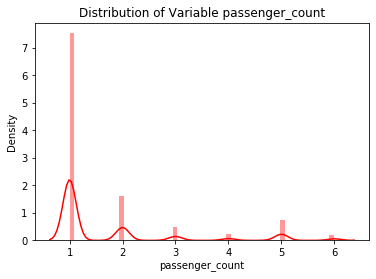

year


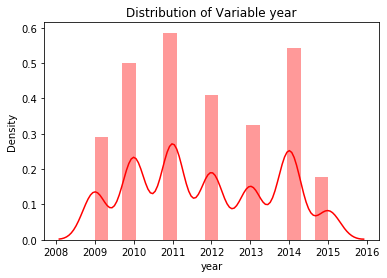

month


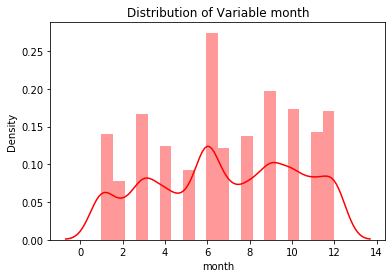

day_of_week


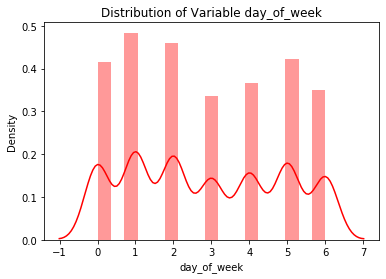

hour


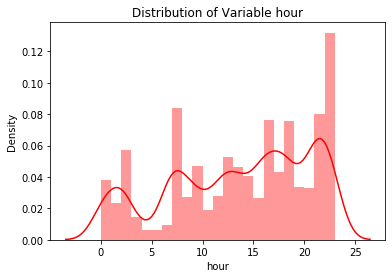

haversine_distance


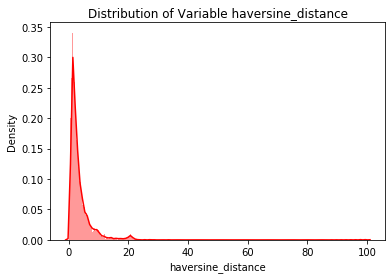

In [15]:
# Normality check for few variables

for i in ['passenger_count', 'year', 'month', 'day_of_week', 'hour', 'haversine_distance']:
    print(i)
    sns.distplot(testData[i], bins='auto', color='red')
    plt.title('Distribution of Variable '+i)
    plt.ylabel('Density')
    plt.show()

In [16]:
# User defined function to take log
new_variables = []
log_data = pd.DataFrame()
def apply_log1p(df, column_names):
    for i in column_names:
        new_col_name = "logOf_{0}".format(i)
        log_data[new_col_name] = np.log1p(df[i])
        new_variables.append(new_col_name)

# Select variables whose values has to be taken log
variables = ['passenger_count', 'year', 'month', 'day_of_week', 'hour', 'haversine_distance']

#Function Call to apply_log1p
apply_log1p(testData, variables)

log_data

,logOf_passenger_count,logOf_year,logOf_month,logOf_day_of_week,logOf_hour,logOf_haversine_distance
0,0.693147,7.608871,0.693147,0.693147,2.639057,1.200946
1,0.693147,7.608871,0.693147,0.693147,2.639057,1.231205
2,0.693147,7.606885,2.397895,1.791759,2.484907,0.481579
3,0.693147,7.607381,2.564949,1.791759,3.091042,1.085538
4,0.693147,7.607381,2.564949,1.791759,3.091042,1.854312
...,...,...,...,...,...,...
9909,1.945910,7.608871,1.791759,1.945910,2.564949,1.139394
9910,1.945910,7.608871,0.693147,0.000000,2.890372,1.451841
9911,1.945910,7.608871,1.609438,1.945910,3.044522,3.004887
9912,1.945910,7.608871,0.693147,1.791759,0.693147,2.234679


logOf_passenger_count


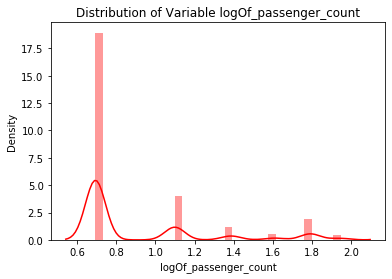

logOf_year


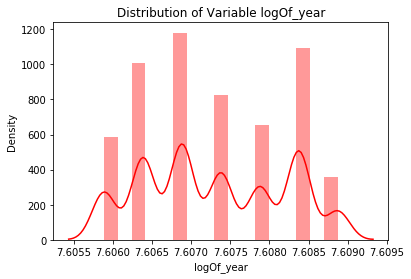

logOf_month


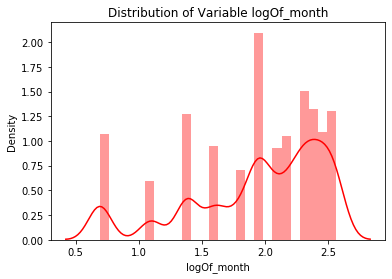

logOf_day_of_week


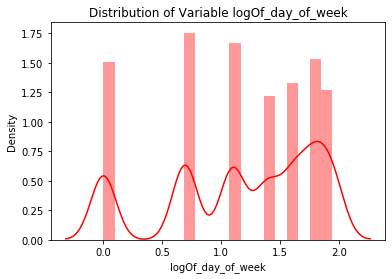

logOf_hour


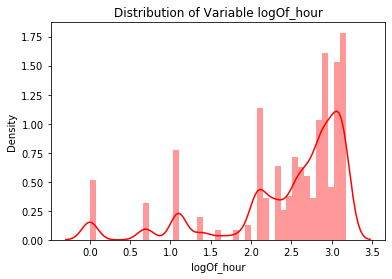

logOf_haversine_distance


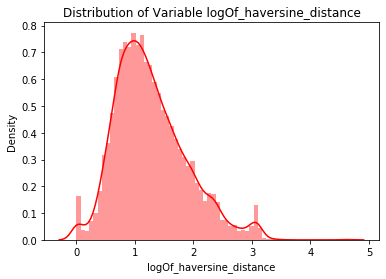

In [17]:
## Confirming Normality check for the variables after log transformation

for i in new_variables:
    print(i)
    sns.distplot(log_data[i], bins='auto', color='red')
    plt.title('Distribution of Variable '+i)
    plt.ylabel('Density')
    plt.show()
    
new_variables = []

In [18]:
# User defined function to take inverse of log
def apply_expm1(df):
    df = np.expm1(df)
    return df

In [19]:
testData.columns

Index(['passenger_count', 'year', 'month', 'day_of_week', 'hour',
       'haversine_distance'],
      dtype='object')

In [20]:
log_data.columns

Index(['logOf_passenger_count', 'logOf_year', 'logOf_month',
       'logOf_day_of_week', 'logOf_hour', 'logOf_haversine_distance'],
      dtype='object')

In [21]:
finalTestData = log_data #testData.drop(['passenger_count', 'year', 'month', 'day_of_week', 'hour', 'haversine_distance'], axis=1)

In [22]:
# load the model
model_LR = pickle.load(open('1.LinearRegressionModel.sav', 'rb'))
LR_predicted = model_LR.predict(finalTestData)

result_LR = pd.DataFrame()
result_LR = testData
result_LR['fare_amount'] = apply_expm1(LR_predicted)
result_LR

,passenger_count,year,month,day_of_week,hour,haversine_distance,fare_amount
0,1,2015,1,1,13,2.323259,9.253714
1,1,2015,1,1,13,2.425353,9.473239
2,1,2011,10,5,11,0.618628,4.639794
3,1,2012,12,5,21,1.961033,8.073942
4,1,2012,12,5,21,5.387301,14.543040
...,...,...,...,...,...,...,...
9909,6,2015,5,6,12,2.124874,9.515753
9910,6,2015,1,0,17,3.270969,11.809224
9911,6,2015,4,6,20,19.183942,37.998876
9912,6,2015,1,5,1,8.343486,20.061538


In [23]:
model_RF = pickle.load(open('2.RandomForestModel.sav', 'rb'))
RF_predicted = model_RF.predict(finalTestData)

result_RF = pd.DataFrame()
result_RF = testData
result_RF['fare_amount'] = apply_expm1(RF_predicted)
result_RF

,passenger_count,year,month,day_of_week,hour,haversine_distance,fare_amount
0,1,2015,1,1,13,2.323259,9.783834
1,1,2015,1,1,13,2.425353,9.726099
2,1,2011,10,5,11,0.618628,3.967778
3,1,2012,12,5,21,1.961033,7.275232
4,1,2012,12,5,21,5.387301,13.870779
...,...,...,...,...,...,...,...
9909,6,2015,5,6,12,2.124874,9.402503
9910,6,2015,1,0,17,3.270969,13.729733
9911,6,2015,4,6,20,19.183942,18.035606
9912,6,2015,1,5,1,8.343486,17.533888


In [24]:
model_DT = pickle.load(open('3.DecisionTreeModel.sav', 'rb'))
DT_predicted = model_DT.predict(finalTestData)

result_DT = pd.DataFrame()
result_DT = testData
result_DT['fare_amount'] = apply_expm1(DT_predicted)
result_DT

,passenger_count,year,month,day_of_week,hour,haversine_distance,fare_amount
0,1,2015,1,1,13,2.323259,16.5
1,1,2015,1,1,13,2.425353,16.5
2,1,2011,10,5,11,0.618628,4.1
3,1,2012,12,5,21,1.961033,9.5
4,1,2012,12,5,21,5.387301,10.5
...,...,...,...,...,...,...,...
9909,6,2015,5,6,12,2.124874,10.5
9910,6,2015,1,0,17,3.270969,10.0
9911,6,2015,4,6,20,19.183942,14.9
9912,6,2015,1,5,1,8.343486,21.0


In [25]:
model_SVR = pickle.load(open('4.SVR_Model.sav', 'rb'))
SVR_predicted = model_SVR.predict(finalTestData)

result_SVR = pd.DataFrame()
result_SVR = testData
result_SVR['fare_amount'] = apply_expm1(SVR_predicted)
result_SVR

,passenger_count,year,month,day_of_week,hour,haversine_distance,fare_amount
0,1,2015,1,1,13,2.323259,8.181557
1,1,2015,1,1,13,2.425353,8.424984
2,1,2011,10,5,11,0.618628,4.499955
3,1,2012,12,5,21,1.961033,7.440826
4,1,2012,12,5,21,5.387301,13.246720
...,...,...,...,...,...,...,...
9909,6,2015,5,6,12,2.124874,8.304896
9910,6,2015,1,0,17,3.270969,11.422839
9911,6,2015,4,6,20,19.183942,20.344500
9912,6,2015,1,5,1,8.343486,13.834420


In [26]:
model_KNR = pickle.load(open('5.K-Neigh_Model.sav', 'rb'))
KNR_predicted = model_KNR.predict(finalTestData)

result_KNR = pd.DataFrame()
result_KNR = testData
result_KNR['fare_amount'] = apply_expm1(KNR_predicted)
result_KNR

,passenger_count,year,month,day_of_week,hour,haversine_distance,fare_amount
0,1,2015,1,1,13,2.323259,7.849152
1,1,2015,1,1,13,2.425353,10.941907
2,1,2011,10,5,11,0.618628,4.822583
3,1,2012,12,5,21,1.961033,7.120570
4,1,2012,12,5,21,5.387301,11.997139
...,...,...,...,...,...,...,...
9909,6,2015,5,6,12,2.124874,6.358687
9910,6,2015,1,0,17,3.270969,9.348544
9911,6,2015,4,6,20,19.183942,14.425610
9912,6,2015,1,5,1,8.343486,12.152461


In [27]:
model_GBR = pickle.load(open('6.GradientBoostingModel.sav', 'rb'))
GBR_predicted = model_GBR.predict(finalTestData)

result_GBR = pd.DataFrame()
result_GBR = testData
result_GBR['fare_amount'] = apply_expm1(GBR_predicted)
result_GBR

,passenger_count,year,month,day_of_week,hour,haversine_distance,fare_amount
0,1,2015,1,1,13,2.323259,9.235861
1,1,2015,1,1,13,2.425353,9.666459
2,1,2011,10,5,11,0.618628,4.552106
3,1,2012,12,5,21,1.961033,7.327432
4,1,2012,12,5,21,5.387301,13.560089
...,...,...,...,...,...,...,...
9909,6,2015,5,6,12,2.124874,10.109114
9910,6,2015,1,0,17,3.270969,12.970788
9911,6,2015,4,6,20,19.183942,18.722266
9912,6,2015,1,5,1,8.343486,19.694828


________________________________________________________________________________________________________________

##############################################################################################################################